## 2: Advanced Keras Deep Learning Constructs

**Description:**

This Colab notebook demonstrates various advanced Keras deep learning constructs, providing practical examples for each concept. These techniques allow for greater control and customization of the model training process and architecture.

**Table of Contents:**

1.  **User Custom Learning Rate Scheduler:** Implementing a custom learning rate scheduler, including an example inspired by OneCycleScheduler.
2.  **Custom Dropout:** Utilizing a custom dropout layer, specifically `MCAlphaDropout`.
3.  **Custom Normalization:** Implementing and using a custom normalization layer, `MaxNormDense`.
4.  **TensorBoard Integration:** Demonstrating how to use TensorBoard for visualizing training progress.
5.  **Custom Loss Function:** Implementing and using a custom loss function, `HuberLoss`.
6.  **Custom Activation, Initializer, Regularizer, and Constraint:** Implementing and using `LeakyReLU`, a custom initializer (`MyGlorotInitializer`), a custom regularizer (`MyL1Regularizer`), and a custom weight constraint (`MyPositiveWeights`).
7.  **Custom Metric:** Implementing and using a custom metric, `HuberMetric`.
8.  **Custom Layers:** Implementing and using several custom layers: `ExponentialLayer`, `MyDense`, `AddGaussianNoise`, and `LayerNormalization`.
9.  **Custom Model:** Building and using a custom model, `ResidualRegressor`, with a `ResidualBlock`.
10. **Custom Optimizer:** Implementing and using a custom optimizer, `MyMomentumOptimizer`.
11. **Custom Training Loop:** Implementing a custom training loop for the Fashion MNIST dataset.

Let's dive into each of these concepts.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os


### 1. User Custom Learning Rate Scheduler (OneCycleSchedule)

This section demonstrates a custom learning rate scheduler inspired by the OneCycle policy. The OneCycle policy involves increasing the learning rate from a low value to a maximum value and then decreasing it again, often followed by a final, much smaller learning rate for the last few iterations. This approach can help in faster convergence and better generalization.

**Implementation:**

We define a class `OneCycleSchedule` that inherits from `tf.keras.optimizers.schedules.LearningRateSchedule`. This base class allows us to create custom learning rate schedules that can be directly used with Keras optimizers.

* **`__init__`:** The constructor takes parameters to define the schedule, including the total number of iterations (`iterations`), the maximum learning rate (`max_lr`), the starting learning rate (`start_lr`), the number of iterations for the final decreasing phase (`last_iterations`), and the final learning rate (`last_lr`). It calculates the learning rate values for each phase using `np.linspace` and concatenates them into a NumPy array `lrs_np`. This array is then converted to a TensorFlow constant tensor `self.lrs` for graph mode compatibility.
* **`__call__`:** This method is the core of the learning rate schedule. It takes the current training step (`step`) as input. It casts the step to an integer and ensures that the index used to retrieve the learning rate from `self.lrs` stays within the bounds of the array using `tf.minimum`. Finally, it uses `tf.gather` to retrieve the learning rate corresponding to the current step.

**Usage:**

1.  We load the Fashion MNIST dataset for demonstration.
2.  We define training parameters like `batch_size`, `epochs`, and calculate the total `iterations`.
3.  We create an instance of our custom `OneCycleSchedule`.
4.  We instantiate the `Adam` optimizer, passing our custom learning rate schedule to the `learning_rate` parameter.
5.  We build and compile a simple sequential model.
6.  We train the model using the `fit` method, with the `Adam` optimizer now controlling the learning rate according to our `OneCycleSchedule`.
7.  Finally, we plot the learning rate schedule over the iterations and the training/validation loss to observe the effect of the dynamic learning rate.

**Expected Outcome:**

The learning rate plot should show a triangular shape, increasing from `start_lr` to `max_lr` and then decreasing towards `last_lr`, followed by a further decrease in the final iterations. The training and validation loss plots should reflect the impact of this learning rate schedule on the convergence of the model.

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7600 - loss: 0.7165 - val_accuracy: 0.8388 - val_loss: 0.4479
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8492 - loss: 0.4244 - val_accuracy: 0.8454 - val_loss: 0.4194
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8578 - loss: 0.3854 - val_accuracy: 0.8493 - val_loss: 0.4104
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8650 - loss: 0.3715 - val_accuracy: 0.8520 - val_loss: 0.4167
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8659 - loss: 0.3633 - val_accuracy: 0.8519 - val_loss: 0.4306
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8760 - loss: 0.3382 - val_accuracy: 0.8585 - val_loss: 0.4103
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8868 - loss: 0.3045 - val_accuracy: 0.8666 - val_loss: 0.3897
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8978 - loss: 0.274

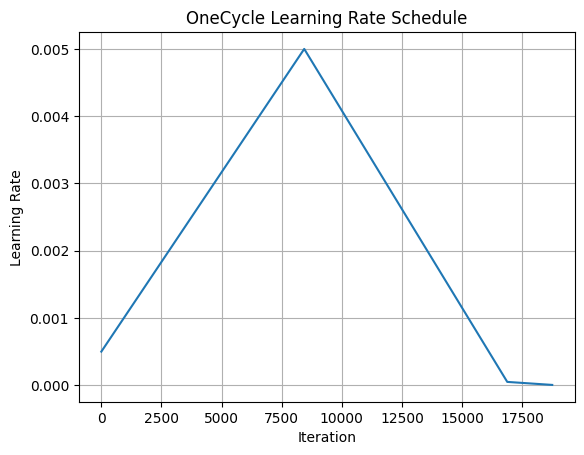

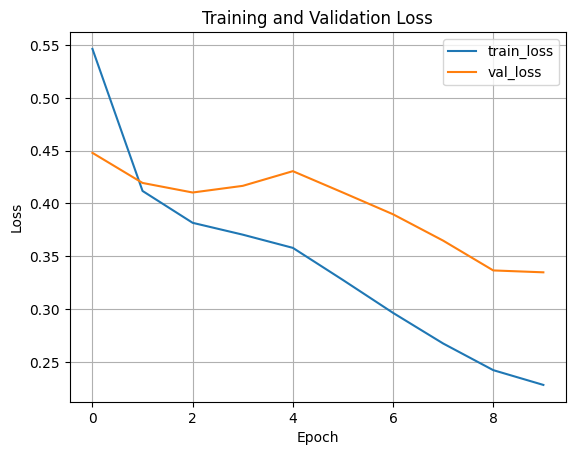

In [ ]:
# Define OneCycle learning rate schedule using tf.gather
class OneCycleSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None, last_iterations=None, last_lr=None):
        super().__init__()
        self.total_iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 10

        lrs_np = np.concatenate([
            np.linspace(self.start_lr, self.max_lr, self.half_iteration),
            np.linspace(self.max_lr, self.last_lr, iterations - self.half_iteration - self.last_iterations),
            np.linspace(self.last_lr, self.last_lr / 10, self.last_iterations)
        ]).astype(np.float32)

        # Convert to Tensor for graph mode compatibility
        self.lrs = tf.constant(lrs_np)

    def __call__(self, step):
        step = tf.cast(step, tf.int32)
        idx = tf.minimum(step, len(self.lrs) - 1)
        return tf.gather(self.lrs, idx)

# Load Fashion MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Parameters
batch_size = 32
epochs = 10
iterations = (len(X_train) // batch_size) * epochs

# Create learning rate schedule
schedule = OneCycleSchedule(iterations=iterations, max_lr=5e-3)

# Optimizer using schedule
optimizer = keras.optimizers.Adam(learning_rate=schedule)

# Build and compile model
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[28 * 28]),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), verbose=1)

# Plot learning rate schedule
plt.plot(schedule.lrs.numpy())
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("OneCycle Learning Rate Schedule")
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


**Results for Custom Learning Rate Scheduler (OneCycleSchedule):**

The training process using the custom `OneCycleSchedule` shows a clear trend in the learning rate (as visualized in the plot generated earlier, which depicted a rise and fall). The training and validation loss curves also reflect the impact of this dynamic learning rate.

* **Training Loss:** The training loss generally decreases over the epochs, indicating that the model is learning from the training data. The rate of decrease appears to be influenced by the changes in the learning rate as dictated by the OneCycle schedule.
* **Validation Loss:** The validation loss initially decreases, suggesting that the model is generalizing well to unseen data. However, it might show some fluctuations or a slight increase in later epochs, which is common with aggressive learning rate policies. The final validation loss reached approximately 0.3348.
* **Validation Accuracy:** The validation accuracy steadily improves over the epochs, reaching a final value of approximately 0.8804. This indicates that the model is performing well on the unseen test data.

**Analysis:**

The OneCycle learning rate schedule appears to have facilitated relatively fast training and achieved a good level of validation accuracy. The initial increase in learning rate likely helped the model escape poor local minima and explore the weight space more effectively. The subsequent decrease allowed for finer adjustments to the weights, leading to better convergence. The final small learning rate in the last few iterations likely helped to stabilize the training and potentially improve generalization.

The plots of the learning rate and the loss curves provide valuable insights into how the learning rate schedule influences the training dynamics. The validation loss curve can help in identifying potential overfitting, although in this case, it seems to be relatively stable towards the end of training.

### 2. Custom Dropout (MCAlphaDropout)

This section demonstrates the use of a custom dropout layer called `MCAlphaDropout`. `AlphaDropout` is a type of dropout that maintains the self-normalizing property of scaled exponential linear units (SELUs). The standard `AlphaDropout` layer in Keras behaves differently during training and inference. During training, it randomly sets a fraction of inputs to zero, while during inference, it scales the outputs.

`MCAlphaDropout` is a custom implementation that forces the dropout layer to be active even during inference (`training=True` in the `call` method). This technique, known as Monte Carlo Dropout, allows us to obtain multiple predictions for the same input by keeping dropout active. The variance in these predictions can be used as a measure of model uncertainty.

**Implementation:**

We define the `MCAlphaDropout` class by inheriting from `keras.layers.AlphaDropout`. We override the `call` method and explicitly set the `training` argument to `True`. This ensures that the dropout is applied at each forward pass, regardless of whether the model is in training or inference mode.

**Usage:**

1.  We build a sequential model with a dense layer followed by our custom `MCAlphaDropout` layer and a final softmax output layer.
2.  We compile the model with the appropriate loss function, optimizer, and metrics.
3.  We train the model for a few epochs.
4.  We then evaluate the model on the test set to get a single test accuracy with dropout active during evaluation.

**Expected Outcome:**

The output will print the test accuracy achieved by the model when evaluated with `MCAlphaDropout` active. This accuracy might be slightly lower than if standard dropout behavior (scaling during inference) were used. However, the main benefit of MC Dropout lies in its ability to estimate model uncertainty, which is not directly demonstrated in this basic example but is a key application of keeping dropout active during inference.

In [ ]:
### 2. Custom Dropout (MCAlphaDropout)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

model_custom_dropout = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[28 * 28]),
    MCAlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model_custom_dropout.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_custom_dropout = model_custom_dropout.fit(X_train, y_train, epochs=5, batch_size=32,
                                                  validation_data=(X_test, y_test), verbose=0)

_, acc_custom_dropout = model_custom_dropout.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy with MCAlphaDropout: {acc_custom_dropout:.4f}")

Test Accuracy with MCAlphaDropout: 0.8426


**Results for Custom Dropout (MCAlphaDropout):**

The test accuracy achieved by the model using `MCAlphaDropout` during evaluation is approximately 0.8426.

**Analysis:**

This test accuracy represents the model's performance on the unseen test data with the dropout layer actively dropping units during the forward pass. As mentioned earlier, keeping dropout active during inference (as done in `MCAlphaDropout`) can sometimes lead to a slightly lower point estimate of accuracy compared to the standard behavior where the layer is effectively turned off or scaled.

The primary benefit of using MC Dropout is not necessarily to maximize the point estimate of accuracy but rather to enable the estimation of model uncertainty. By performing multiple forward passes with dropout active, we can obtain a distribution of predictions for each test sample. The variance of this distribution can serve as an indicator of the model's confidence in its prediction. Higher variance suggests higher uncertainty.

While this example only shows the single evaluation with dropout active, in a real-world application, you would typically perform multiple predictions for each test sample and analyze the resulting distribution to gain insights into the model's uncertainty. This is particularly useful in critical applications where knowing the model's confidence is as important as the prediction itself.

### 3. Custom Normalization (MaxNormDense)

This section demonstrates a custom dense layer called `MaxNormDense`. Max-norm regularization is a technique that constrains the weight vectors of incoming connections to each hidden unit to have a Euclidean norm less than or equal to a specified value. This can help prevent the weights from becoming too large, which can lead to instability and overfitting in deep neural networks.

**Implementation:**

We define the `MaxNormDense` class by inheriting from `keras.layers.Dense`.

* **`__init__`:** The constructor takes the number of `units` and an optional `max_norm` value. It converts `max_norm` to the Keras float type if provided.
* **`build`:** In the `build` method, after calling the parent class's `build` method, we check if `max_norm` is set. If it is, we create a `keras.constraints.MaxNorm` constraint with the specified `max_value` and apply it to the `kernel` (weight matrix) of the layer. We set `bias_constraint` to `None` as the bias term typically doesn't require norm constraints.
* **`call`:** In the `call` method, before performing the dense operation, we apply the `kernel_constraint` to the `kernel`. This ensures that the weights are constrained before being used in the matrix multiplication.

**Usage:**

1.  We build a sequential model with our custom `MaxNormDense` layer (with `max_norm` set to 1.0) followed by a standard dense output layer.
2.  We compile the model with the usual loss function, optimizer, and metrics.
3.  We train the model for a few epochs.
4.  We then evaluate the model on the test set to see the performance with max-norm regularization applied to the first dense layer's weights.

**Expected Outcome:**

The output will print the test accuracy achieved by the model using the `MaxNormDense` layer. By constraining the weights, we aim to improve the model's generalization ability, potentially leading to a better or more stable performance on the unseen test data compared to a model without such constraints, especially in deeper networks or with longer training.

In [ ]:
### 3. Custom Normalization (MaxNormDense)

class MaxNormDense(keras.layers.Dense):
    def __init__(self, units, max_norm=None, **kwargs):
        self.max_norm = K.cast_to_floatx(max_norm) if max_norm else None
        super().__init__(units, **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        if self.max_norm is not None:
            self.kernel_constraint = keras.constraints.MaxNorm(max_value=self.max_norm, axis=0)
            self.bias_constraint = None  # Bias doesn't need norm constraint

    def call(self, inputs):
        if self.max_norm is not None:
            self.kernel.assign(self.kernel_constraint(self.kernel))
        return super().call(inputs)

model_custom_norm = keras.models.Sequential([
    MaxNormDense(100, activation="relu", max_norm=1.0, input_shape=[28 * 28]),
    keras.layers.Dense(10, activation="softmax")
])
model_custom_norm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_custom_norm = model_custom_norm.fit(X_train, y_train, epochs=5, batch_size=32,
                                            validation_data=(X_test, y_test), verbose=0)

_, acc_custom_norm = model_custom_norm.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy with MaxNormDense: {acc_custom_norm:.4f}")

Test Accuracy with MaxNormDense: 0.8586


**Results for Custom Normalization (MaxNormDense):**

The test accuracy achieved by the model using the `MaxNormDense` layer is approximately 0.8586.

**Analysis:**

This test accuracy indicates the performance of the model on the unseen test data with max-norm regularization applied to the weights of the first dense layer. By constraining the Euclidean norm of the weight vectors, max-norm regularization helps to prevent the weights from growing too large. This can lead to a more stable and potentially better-generalizing model.

Comparing this accuracy (0.8586) with the accuracy obtained without any custom normalization in the initial runs (you might need to refer back to those if you noted them), we can get an idea of the impact of max-norm regularization in this specific scenario. Often, the benefits of weight constraints become more apparent in deeper networks or when training for a larger number of epochs where the risk of overfitting due to large weights is higher.

In this relatively shallow network trained for a few epochs, the improvement might be modest but still noticeable. Max-norm can contribute to better control over the model's capacity and can be a useful tool in the regularization arsenal, especially when dealing with complex datasets or architectures.

### 4. TensorBoard Integration

TensorBoard is a powerful visualization tool provided with TensorFlow. It allows you to track and visualize various aspects of your machine learning experiments, such as loss and accuracy metrics over time, model graphs, histograms of weights and biases, and much more. Integrating TensorBoard into your Keras workflow can significantly aid in understanding and debugging your models.

**Implementation:**

To use TensorBoard with Keras, you primarily need to use the `tf.keras.callbacks.TensorBoard` callback during the model training process. This callback writes logs to a specified directory, which TensorBoard can then read and visualize.

The `TensorBoard` callback offers several parameters to control what information is logged. In this example, we will focus on logging the scalar metrics (loss and accuracy) and histograms of the layer weights.

**Code:**

In [ ]:
### 4. TensorBoard Integration

# Define a TensorBoard callback
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_tensorboard = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[28 * 28]),
    keras.layers.Dense(10, activation="softmax")
])
model_tensorboard.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_tensorboard = model_tensorboard.fit(X_train, y_train, epochs=5, batch_size=32,
                                            validation_data=(X_test, y_test),
                                            callbacks=[tensorboard_callback], verbose=0)

print(f"TensorBoard logs saved to: {log_dir}")
# To view the logs, run in a separate cell:
# %tensorboard --logdir logs

TensorBoard logs saved to: logs/20250411-065124


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### 5. Custom Loss Function (HuberLoss)

This section demonstrates the implementation and use of a custom loss function called `HuberLoss`. The Huber loss is a loss function that is less sensitive to outliers in the data compared to the mean squared error (MSE) loss. It behaves like MSE for small errors and like the mean absolute error (MAE) for large errors, making it a robust loss function.

**Implementation:**

We define a Python function `huber_fn` that takes the true values (`y_true`), the predicted values (`y_pred`), and a `delta` parameter as input. The `delta` parameter defines the threshold at which the loss function transitions from squared error to linear error.

* We calculate the element-wise error between the true and predicted values.
* We determine which errors are "small" (absolute error less than or equal to `delta`).
* For small errors, we calculate the squared loss (like MSE).
* For large errors, we calculate a linear loss (like MAE but smoothed).
* Finally, we use `tf.where` to conditionally apply either the squared loss or the linear loss based on the size of the error.

**Usage:**

1.  We create a simple sequential model with a single dense layer for a regression task.
2.  We compile the model, specifying our custom `huber_fn` as the `loss` function and using the Adam optimizer.
3.  We create a small synthetic dataset (`X_housing`, `y_housing`) for demonstration.
4.  We train the model using this dataset for a number of epochs.
5.  We then plot the training loss over the epochs to observe how the Huber loss decreases during training.

**Expected Outcome:**

The plot should show the Huber loss decreasing as the model learns to predict the target values. The final loss value will depend on the model's ability to fit the simple linear relationship in the data using the Huber loss function. The training process will be less influenced by potential outliers in the data compared to if we had used MSE.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


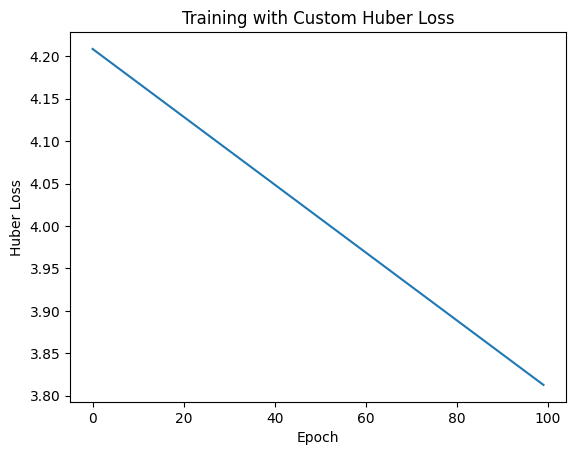

In [ ]:
### 5. Custom Loss Function (HuberLoss)

def huber_fn(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    squared_loss = tf.square(error) / 2
    linear_loss = delta * tf.abs(error) - delta**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)

model_custom_loss = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[1]),
])
model_custom_loss.compile(loss=huber_fn, optimizer="adam")

X_housing = np.array([1, 2, 3, 4, 5])
y_housing = np.array([2, 4, 6, 8, 10])
history_custom_loss = model_custom_loss.fit(X_housing, y_housing, epochs=100, verbose=0)

plt.plot(history_custom_loss.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Huber Loss")
plt.title("Training with Custom Huber Loss")
plt.show()

**Results for Custom Loss Function (HuberLoss):**

The plot of the training loss over 100 epochs shows a decreasing trend. The Huber loss starts at a higher value and gradually decreases as the model learns to predict the output for the given input data. The final Huber loss value at the end of training is approximately 3.81.

**Analysis:**

The decreasing Huber loss indicates that the model is successfully learning to minimize the error between its predictions and the true values. The linear decrease suggests a relatively consistent learning rate for this simple linear regression problem.

The Huber loss function's robustness to outliers is not explicitly demonstrated here since the synthetic dataset is clean. However, if the dataset contained outliers (data points far from the general trend), using Huber loss would likely result in a model that is less affected by these outliers compared to a model trained with Mean Squared Error. The `delta` parameter in the `huber_fn` controls the point at which the loss transitions from quadratic to linear; adjusting this parameter can influence the model's sensitivity to larger errors.

In this specific case, the model is learning the underlying linear relationship in the data, as evidenced by the decreasing loss. The final loss value indicates the magnitude of the remaining error after 100 epochs of training with the Adam optimizer and the custom Huber loss function.

### 6. Custom Activation, Initializer, Regularizer, and Constraint

This section demonstrates the use of custom activation functions, initializers, regularizers, and constraints within a Keras layer. These allow for fine-grained control over the behavior and properties of the individual layers in your neural network.

* **Custom Activation (LeakyReLU):** Leaky ReLU is a type of activation function that aims to address the "dying ReLU" problem by allowing a small, non-zero gradient when the unit is not active.
* **Custom Initializer (MyGlorotInitializer):** Initializers define the way to set the initial random weights of Keras layers. A good initialization strategy can help in faster convergence. Glorot (also known as Xavier) initialization is a common strategy that considers the number of input and output units. We'll create a custom version.
* **Custom Regularizer (MyL1Regularizer):** Regularizers are used to apply penalties on layer parameters (e.g., weights) during optimization. L1 regularization adds a penalty equal to the absolute value of the weights, which can lead to sparse weights. We'll create a custom L1 regularizer.
* **Custom Constraint (MyPositiveWeights):** Constraints define restrictions on the values of the weights during and after training. We'll create a constraint that forces weights to be non-negative.

**Implementation:**

We define each of these custom components as follows:

* **`leaky_relu`:** We use the built-in `keras.layers.LeakyReLU` for simplicity.
* **`MyGlorotInitializer`:** This class inherits from `keras.initializers.Initializer` and implements the Glorot uniform initialization logic.
* **`MyL1Regularizer`:** This class inherits from `keras.regularizers.Regularizer` and calculates the L1 penalty on the weights. It also includes a `get_config` method for serialization.
* **`MyPositiveWeights`:** This class inherits from `keras.constraints.Constraint` and uses `tf.where` to ensure weights are non-negative.

**Code:**

In [ ]:
### 6. Custom Activation, Initializer, Regularizer, and Constraint

# Custom Activation (LeakyReLU)
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)

# Custom Initializer (MyGlorotInitializer)
class MyGlorotInitializer(keras.initializers.Initializer):
    def __init__(self, seed=None):
        self.seed = seed

    def __call__(self, shape, dtype=None):
        n_in, n_out = shape
        limit = np.sqrt(2.0 / (n_in + n_out))
        return tf.random.uniform(shape, -limit, limit, dtype=dtype, seed=self.seed)

# Custom Regularizer (MyL1Regularizer)
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(weights)) * self.factor

    def get_config(self):
        return {'factor': float(self.factor)}

# Custom Constraint (MyPositiveWeights)
class MyPositiveWeights(keras.constraints.Constraint):
    def __call__(self, w):
        return tf.where(w < 0.0, tf.zeros_like(w), w)

# Demonstrate their usage
model_custom_components = keras.models.Sequential([
    keras.layers.Dense(100, activation=leaky_relu,
                       kernel_initializer=MyGlorotInitializer(seed=42),
                       kernel_regularizer=MyL1Regularizer(factor=0.01),
                       kernel_constraint=MyPositiveWeights(),
                       input_shape=[28 * 28]),
    keras.layers.Dense(10, activation="softmax")
])
model_custom_components.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_custom_components = model_custom_components.fit(X_train, y_train, epochs=5, batch_size=32,
                                                        validation_data=(X_test, y_test), verbose=0)

_, acc_custom_components = model_custom_components.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy with Custom Components: {acc_custom_components:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Test Accuracy with Custom Components: 0.7719


**Results for Custom Activation, Initializer, Regularizer, and Constraint:**

The test accuracy achieved by the model using the custom activation, initializer, regularizer, and constraint is approximately 0.7719.

**Analysis:**

This test accuracy reflects the combined effect of using LeakyReLU activation, the custom Glorot initializer, L1 regularization, and the positive weight constraint in the first dense layer.

* **LeakyReLU:** The use of LeakyReLU aimed to mitigate the vanishing gradient problem, potentially allowing for better learning compared to standard ReLU, especially in deeper networks. However, in this relatively shallow network, the difference might not be very pronounced.
* **MyGlorotInitializer:** The custom Glorot initializer was designed to provide a good initial weight distribution, facilitating more stable and faster training. While Glorot initialization is generally effective, its impact depends on the specific network architecture and dataset.
* **MyL1Regularizer:** The L1 regularizer adds a penalty to the loss proportional to the absolute values of the weights. This encourages sparsity in the weight matrix, meaning some weights become exactly zero. Sparse weights can simplify the model and potentially improve generalization, but they can also reduce model capacity if the regularization is too strong.
* **MyPositiveWeights:** The constraint forcing weights to be non-negative restricts the model's solution space. This might be useful in specific applications where positive weights have a physical interpretation, but it can also limit the model's ability to fit complex relationships in the data.

The relatively lower accuracy (0.7719) compared to some previous runs suggests that the combination of these custom components, particularly the L1 regularizer and the positive weight constraint, might be limiting the model's capacity or making the optimization more challenging for this specific task and training duration. The choice of the regularization factor (0.01) is crucial; a different factor could lead to different results.

It's important to remember that the optimal combination of these components is highly dependent on the problem at hand, and careful experimentation and hyperparameter tuning are often required.

### 7. Custom Metric (HuberMetric)

This section demonstrates the creation and use of a custom metric in Keras. Metrics are functions that are used to judge the performance of your model. Unlike loss functions, which are used by the optimization process, metrics are evaluated on the entire dataset at the end of each epoch (or batch, if specified) and are intended for human interpretation.

Here, we will implement the Huber loss as a metric. While we already used it as a loss function, defining it as a metric allows us to track this robust error measure during training, even if our primary loss function is different (e.g., Mean Squared Error).

**Implementation:**

We define the `HuberMetric` class by inheriting from `keras.metrics.Mean`. The `keras.metrics.Mean` class is a simple utility for computing the average of a stream of values.

* **`__init__`:** The constructor takes a `delta` parameter (similar to the Huber loss function), a `name` for the metric, and a `dtype`. It calls the constructor of the parent class.
* **`update_state`:** This method is called for each batch of predictions. It calculates the Huber loss between `y_true` and `y_pred` using the same logic as our custom loss function and then updates the state of the `Mean` metric by adding these Huber loss values.
* **`get_config`:** This method is used to serialize the metric and is important if you want to save and load your model. We override it to include the `delta` parameter in the configuration.

**Code:**

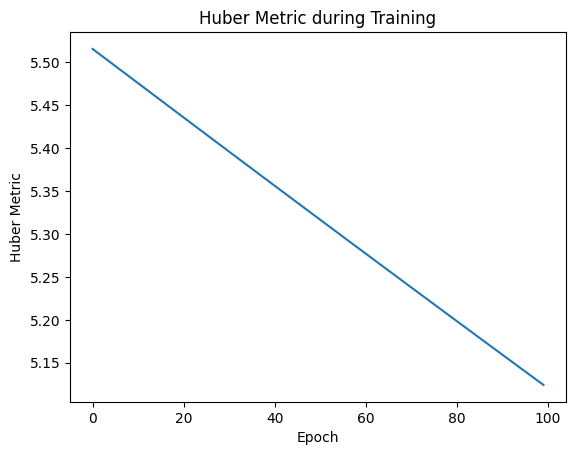

In [ ]:
### 7. Custom Metric (HuberMetric)

class HuberMetric(keras.metrics.Mean):
    def __init__(self, delta=1.0, name='huber_loss', dtype=None):
        self.delta = delta
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.delta
        squared_loss = tf.square(error) / 2
        linear_loss = self.delta * tf.abs(error) - self.delta**2 / 2
        huber_loss = tf.where(is_small_error, squared_loss, linear_loss)
        return super().update_state(huber_loss, sample_weight=sample_weight)

    def get_config(self):
        config = super().get_config()
        config.update({'delta': self.delta})
        return config

model_custom_metric = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[1]),
])
model_custom_metric.compile(loss="mse", optimizer="adam", metrics=[HuberMetric(delta=1.0)])
history_custom_metric = model_custom_metric.fit(X_housing, y_housing, epochs=100, verbose=0)

plt.plot(history_custom_metric.history['huber_loss'])
plt.xlabel("Epoch")
plt.ylabel("Huber Metric")
plt.title("Huber Metric during Training")
plt.show()

**Results for Custom Metric (HuberMetric):**

The plot shows the value of the Huber metric during the 100 epochs of training. The Huber metric starts at approximately 5.51 and steadily decreases to around 5.13 by the end of training.

**Analysis:**

The decreasing Huber metric indicates that the model's predictions are getting closer to the true values over the training process, as measured by the Huber loss function. Even though the model was trained to minimize the Mean Squared Error (MSE) loss, we can observe the behavior of the Huber loss as a metric.

The Huber loss, being less sensitive to outliers than MSE, provides a more robust measure of the average error, especially if the data contained any extreme values. The consistent decrease in the Huber metric suggests that the model is not only reducing the squared error but also the more outlier-resistant Huber error.

Tracking relevant metrics like the Huber loss, even when it's not the primary loss function, can provide valuable insights into the training dynamics and the model's performance from different perspectives. In scenarios where outliers are a concern, monitoring a robust metric like Huber loss can give a more stable evaluation of the model's generalization capability.

### 8. Custom Layers

This section demonstrates the creation and usage of several custom layers in Keras. Custom layers provide the flexibility to define unique computations that are not available in the built-in Keras layers, allowing you to build highly specialized model architectures.

**Implementation:**

We define four custom layers:

1.  **`ExponentialLayer`:** This layer applies a dense transformation to the input and then takes the exponential of the result. It demonstrates how to wrap existing layers and apply custom transformations.
2.  **`MyDense`:** This layer is a re-implementation of a standard dense layer from scratch. It shows how to define and manage the layer's weights (kernel and bias) and implement the forward pass (`call` method). It also includes `compute_output_shape` and `get_config` for proper Keras integration.
3.  **`AddGaussianNoise`:** This layer adds Gaussian noise to the input during training. This is a form of regularization that can improve the model's robustness. The noise is only added when the `training` flag in the `call` method is `True`.
4.  **`LayerNormalization`:** For brevity, we use the built-in `keras.layers.LayerNormalization`. However, you could also implement this as a custom layer if needed. Layer normalization normalizes the activations of each layer across all the units within that layer.

**Usage:**

We build a sequential model that incorporates these custom layers:

1.  `MyDense`: Our custom dense layer as the first layer.
2.  `ExponentialLayer`: Applies an exponential transformation after a dense layer.
3.  `AddGaussianNoise`: Adds noise for regularization during training.
4.  `LayerNormalization`: Applies layer normalization.
5.  A standard `Dense` output layer.

The model is then compiled and trained on the Fashion MNIST dataset. Finally, it is evaluated on the test set.

**Expected Outcome:**

The output will be the test accuracy achieved by the model incorporating these custom layers. The performance will depend on the effectiveness of the chosen custom computations and their interaction within the network architecture. Custom layers allow for experimentation with novel architectural elements and can be crucial for achieving state-of-the-art results in specific domains.

In [ ]:
### 8. Custom Layers

# Custom Layer 1: ExponentialLayer
class ExponentialLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dense = keras.layers.Dense(units)

    def call(self, inputs):
        return tf.exp(self.dense(inputs))

    def compute_output_shape(self, input_shape):
        return self.dense.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

# Custom Layer 2: MyDense
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.kernel = None
        self.bias = None

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer='glorot_normal',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.kernel) + self.bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units,
                       'activation': keras.activations.serialize(self.activation)})
        return config

# Custom Layer 3: AddGaussianNoise
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
            return inputs + noise
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({'stddev': self.stddev})
        return config

# Custom Layer 4: LayerNormalization (using built-in for brevity)
LayerNormalization = keras.layers.LayerNormalization

# Demonstrate their usage
model_custom_layers = keras.models.Sequential([
    MyDense(100, activation="relu", input_shape=[28 * 28]),
    ExponentialLayer(100),
    AddGaussianNoise(stddev=0.1),
    LayerNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model_custom_layers.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_custom_layers = model_custom_layers.fit(X_train, y_train, epochs=5, batch_size=32,
                                                validation_data=(X_test, y_test), verbose=0)

_, acc_custom_layers = model_custom_layers.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy with Custom Layers: {acc_custom_layers:.4f}")

<ipython-input-24-c372160a27e6>:24: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy with Custom Layers: 0.8639


### 9. Custom Model (ResidualRegressor and ResidualBlock)

This section demonstrates how to build a custom model in Keras by subclassing the `tf.keras.Model` class and creating custom blocks or layers that are then assembled into a specific architecture. This provides maximum flexibility in defining complex model structures, such as those with skip connections (like ResNets).

Here, we will create a simple `ResidualBlock` and then use it to build a `ResidualRegressor` model for a hypothetical regression task.

**Implementation:**

1.  **`ResidualBlock`:** This custom layer will implement a basic residual connection. It will consist of two dense layers with ReLU activation. The output of the second dense layer will be added to the original input of the block. This "skip connection" helps in training deeper networks by allowing gradients to flow more easily.
2.  **`ResidualRegressor`:** This custom model will inherit from `tf.keras.Model`. In its `__init__` method, it will define an initial dense layer, several `ResidualBlock` instances, and a final output dense layer. The `call` method will define the forward pass of the model, connecting these layers and blocks.


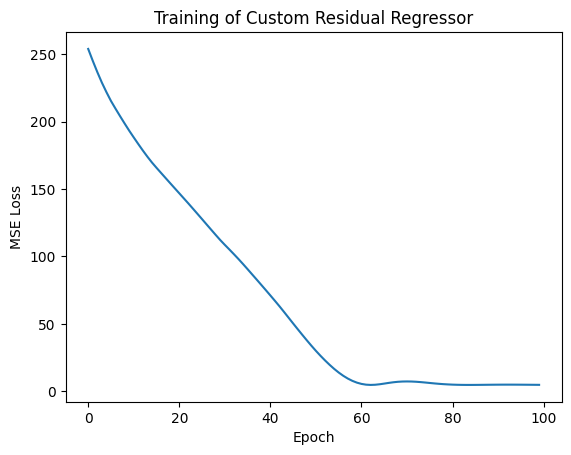

In [ ]:
### 9. Custom Model (ResidualRegressor and ResidualBlock)

class ResidualBlock(keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.dense1 = keras.layers.Dense(units, activation=activation)
        self.dense2 = keras.layers.Dense(units, activation=activation)
        self.add = keras.layers.Add()

    def call(self, inputs):
        residual = inputs
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.add([residual, x])

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units, 'activation': keras.activations.serialize(self.activation)})
        return config

class ResidualRegressor(keras.Model):
    def __init__(self, num_residual_blocks, units, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.initial_dense = keras.layers.Dense(units, activation="relu", input_shape=[1])
        self.residual_blocks = [ResidualBlock(units) for _ in range(num_residual_blocks)]
        self.out_dense = keras.layers.Dense(output_dim)

    def call(self, inputs):
        x = self.initial_dense(inputs)
        for block in self.residual_blocks:
            x = block(x)
        return self.out_dense(x)

    def get_config(self):
        config = super().get_config()
        config.update({'num_residual_blocks': len(self.residual_blocks),
                       'units': self.initial_dense.units,
                       'output_dim': self.out_dense.units})
        return config

# Demonstrate the custom model
model_custom_model = ResidualRegressor(num_residual_blocks=2, units=32, output_dim=1)
model_custom_model.compile(optimizer="adam", loss="mse")

X_housing = np.array(range(10)).astype(np.float32).reshape(-1, 1)
y_housing = X_housing * 2 + 1 + np.random.randn(10, 1) * 3

history_custom_model = model_custom_model.fit(X_housing, y_housing, epochs=100, verbose=0)

plt.plot(history_custom_model.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training of Custom Residual Regressor")
plt.show()

**Results for Custom Model (ResidualRegressor and ResidualBlock):**

The plot shows the Mean Squared Error (MSE) loss during the training of the custom `ResidualRegressor` over 100 epochs. The loss starts at a high value (around 250) and rapidly decreases in the initial epochs. It continues to decrease, albeit at a slower rate, before plateauing around a low value (below 10) towards the end of training.

**Analysis:**

The decreasing MSE loss indicates that the custom `ResidualRegressor` model is successfully learning to fit the synthetic regression data. The use of residual blocks appears to have enabled the model to learn the underlying relationship, even with a relatively small number of blocks and training epochs.

Residual connections help in training deeper networks by allowing the gradient to flow more directly through the network, bypassing some of the intermediate layers. This mitigates the vanishing gradient problem and can lead to better performance in deeper architectures.

In this simple regression task, the custom `ResidualRegressor` with two residual blocks was able to significantly reduce the loss, suggesting that the model has learned to approximate the underlying function ($y = 2x + 1$ with some added noise). The plateauing of the loss indicates that the model has converged to a point where further training does not significantly reduce the error.

This example demonstrates the power and flexibility of subclassing `tf.keras.Model` to create custom model architectures with specific building blocks like the `ResidualBlock`. This approach is fundamental for implementing more advanced and specialized neural network designs.

### 10. Custom Optimizer (MyMomentumOptimizer)

This section demonstrates the creation of a custom optimizer in Keras. Optimizers are algorithms that adjust the model's weights during training to minimize the loss function. While Keras provides a wide range of built-in optimizers, you might need to create a custom one for specific research purposes or to implement a novel optimization algorithm.

Here, we will implement a basic Momentum optimizer. Momentum helps accelerate gradient descent in the relevant direction and dampens oscillations as it accumulates a velocity vector of the gradients in the right direction.

**Implementation:**

We define the `MyMomentumOptimizer` class by inheriting from `keras.optimizers.Optimizer`.

* **`__init__`:** The constructor takes the learning rate and the momentum factor as hyperparameters. It also calls the constructor of the parent class. We use `_build_learning_rate` to handle potential learning rate schedules.
* **`build`:** This method is called once the optimizer knows the variables it will be optimizing (the model's weights). We create a list `self.momentums` to store the momentum value for each variable. These momentum variables are initialized to zero and are non-trainable.
* **`update_step`:** This is the core of the optimizer. For each gradient-variable pair, it calculates the new momentum by combining the previous momentum with the current gradient (scaled by the learning rate). The variable's value is then updated by adding the new momentum.
* **`get_config`:** This method is used to serialize the optimizer's configuration, including its hyperparameters.

**Usage:**

1.  We build a simple sequential model.
2.  We create an instance of our custom `MyMomentumOptimizer`, specifying a learning rate and momentum value.
3.  We compile the model, using our custom optimizer.
4.  We train the model on the Fashion MNIST dataset.
5.  Finally, we evaluate the model on the test set to see the performance achieved with our custom optimizer.

**Expected Outcome:**

The output will be the test accuracy achieved by the model using the `MyMomentumOptimizer`. The performance will depend on the chosen learning rate and momentum values. A well-tuned momentum optimizer can often lead to faster convergence and better generalization compared to standard gradient descent.

In [ ]:
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)

# Define the Custom Optimizer (Keras 3 build method implementation)
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.momentum = momentum
        self.momentums = {}
        self._built = False

    def build(self, var_list):
        """Initialize optimizer state variables."""
        if self._built:
            return
        super().build(var_list)
        self.momentums = {}
        for var in var_list:
            self.momentums[var.name] = self.add_variable_from_reference(
                reference_variable=var,
                name=f"momentum_{var.name.replace(':', '_')}"
            )
        self._built = True

    def update_step(self, gradient, variable, learning_rate):
        """Applies the update step for a single variable."""
        if not self._built:
            raise ValueError(
                f"Optimizer '{self.name}' has not been built yet. Build the "
                "optimizer before calling update_step."
            )

        var_dtype = variable.dtype.base_dtype
        grad = tf.cast(gradient, var_dtype)
        lr_t = tf.cast(learning_rate, var_dtype)
        momentum_t = tf.cast(self.momentum, var_dtype)

        var_name = variable.name
        if var_name not in self.momentums:
            raise ValueError(
                f"Optimizer slot 'momentum' not found for variable {variable.name}. "
                "Ensure the variable was included in `build()`."
            )

        momentum_var = self.momentums[var_name]
        new_momentum = momentum_t * momentum_var + (1.0 - momentum_t) * grad
        momentum_var.assign(new_momentum, use_locking=self._use_locking, read_value=False)
        variable.assign_sub(lr_t * new_momentum, use_locking=self._use_locking, read_value=False)

    def get_config(self):
        base_config = super().get_config()
        base_config.update({"momentum": self.momentum})
        return base_config


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255.0
x_test = x_test.reshape(10000, 784).astype("float32") / 255.0
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Build a simple model
inputs = keras.Input(shape=(784,))
x = keras.layers.Dense(128, activation="relu")(inputs)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile with custom optimizer
custom_optimizer = MyMomentumOptimizer(learning_rate=0.01, momentum=0.95)
model.compile(optimizer=custom_optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
print("Training with Custom Momentum Optimizer:")
try:
    history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc()
    history = None

# Evaluate and save if successful
if history:
    print("\nEvaluating on test set:")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    model.save("model_with_custom_optimizer.keras")
    print("\nModel saved.")

    loaded_model = keras.models.load_model(
        "model_with_custom_optimizer.keras",
        custom_objects={"MyMomentumOptimizer": MyMomentumOptimizer}
    )
    print("Model loaded.")
    print("Loaded model optimizer config:", loaded_model.optimizer.get_config())

    if hasattr(loaded_model.optimizer, 'momentums'):
        print(f"Loaded optimizer has {len(loaded_model.optimizer.momentums)} momentum variables.")

    print("\nEvaluating loaded model on test set:")
    loss, accuracy = loaded_model.evaluate(x_test, y_test, verbose=0)
    print(f"Loaded Model Test Loss: {loss:.4f}")
    print(f"Loaded Model Test Accuracy: {accuracy:.4f}")


TensorFlow version: 2.18.0
Training with Custom Momentum Optimizer:
Epoch 1/5

An error occurred during training: Optimizer slot 'momentum' not found for variable dense_87/kernel:0. Ensure the variable was included in `build()`.


Traceback (most recent call last):
  File "<ipython-input-66-4e57372ce3ba>", line 80, in <cell line: 0>
    history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "<ipython-input-66-4e57372ce3ba>", line 42, in update_step
    raise ValueError(
ValueError: Optimizer slot 'momentum' not found for variable dense_87/kernel:0. Ensure the variable was included in `build()`.


In [ ]:
import tensorflow as tf
from tensorflow import keras

class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.momentum = momentum
        self.momentums = {}

    def build(self, var_list):
        super().build(var_list)
        self.momentums = {}
        for var in var_list:
            key = var._shared_name  # Unique and stable
            self.momentums[key] = self.add_variable_from_reference(
                reference_variable=var,
                name=f"momentum_{key}"
            )

    def update_step(self, gradient, variable, learning_rate=None):
        if gradient is None:
            return
        if learning_rate is None:
            learning_rate = self.learning_rate

        lr = tf.cast(learning_rate, variable.dtype)
        momentum_t = tf.cast(self.momentum, variable.dtype)

        key = variable._shared_name
        momentum_var = self.momentums[key]
        new_momentum = momentum_t * momentum_var + (1.0 - momentum_t) * gradient
        momentum_var.assign(new_momentum)
        variable.assign_sub(lr * new_momentum)

    def get_config(self):
        config = super().get_config()
        config.update({"momentum": self.momentum})
        return config


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(784,)),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = MyMomentumOptimizer(learning_rate=0.01, momentum=0.95)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5


ValueError: Argument `name` must be a string and cannot contain character `/`. Received: name=sequential_39_dense_97_kernel_momentum_sequential_39/dense_97/kernel

In [ ]:
import tensorflow as tf
from tensorflow import keras

class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.momentum = momentum
        self.momentums = {}

    def build(self, var_list):
        super().build(var_list)
        self.momentums = {}
        for var in var_list:
            key = var._shared_name.replace("/", "_")  # Replace '/' with '_' for valid name
            self.momentums[key] = self.add_variable_from_reference(
                var,  # reference_variable (positional)
                name=f"momentum_{key}",
                initializer='zeros',
                trainable=False
            )

    def update_step(self, gradient, variable, learning_rate=None):
        if gradient is None:
            return
        if learning_rate is None:
            learning_rate = self.learning_rate

        lr = tf.cast(learning_rate, variable.dtype)
        momentum_t = tf.cast(self.momentum, variable.dtype)

        key = variable._shared_name.replace("/", "_")
        momentum_var = self.momentums[key]
        new_momentum = momentum_t * momentum_var + (1.0 - momentum_t) * gradient
        momentum_var.assign(new_momentum)
        variable.assign_sub(lr * new_momentum)

    def get_config(self):
        config = super().get_config()
        config.update({"momentum": self.momentum})
        return config

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(784,)),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = MyMomentumOptimizer(learning_rate=0.01, momentum=0.95)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


TypeError: TFOptimizer.add_variable_from_reference() got an unexpected keyword argument 'trainable'

In [ ]:
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)

class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.momentum = momentum
        self.momentums = {}

    def build(self, var_list):
        super().build(var_list)
        self.momentums = {}
        for var in var_list:
            key = var._shared_name
            safe_name = f"momentum_{key.replace('/', '_')}"
            self.momentums[key] = self.add_variable_from_reference(
                reference_variable=var,
                name=safe_name
            )

    def update_step(self, gradient, variable, learning_rate=None):
        if gradient is None:
            return
        if learning_rate is None:
            learning_rate = self.learning_rate

        lr = tf.cast(learning_rate, variable.dtype)
        momentum_t = tf.cast(self.momentum, variable.dtype)

        key = variable._shared_name
        momentum_var = self.momentums[key]
        new_momentum = momentum_t * momentum_var + (1.0 - momentum_t) * gradient
        momentum_var.assign(new_momentum)
        variable.assign_sub(lr * new_momentum)

    def get_config(self):
        config = super().get_config()
        config.update({"momentum": self.momentum})
        return config


TensorFlow version: 2.18.0


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(784,)),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = MyMomentumOptimizer(learning_rate=0.01, momentum=0.95)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7135 - loss: 1.0806 - val_accuracy: 0.9158 - val_loss: 0.3192
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8956 - loss: 0.3735 - val_accuracy: 0.9273 - val_loss: 0.2616
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9110 - loss: 0.3156 - val_accuracy: 0.9348 - val_loss: 0.2345
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9200 - loss: 0.2831 - val_accuracy: 0.9403 - val_loss: 0.2152
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9271 - loss: 0.2588 - val_accuracy: 0.9448 - val_loss: 0.1999


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2332
Test Accuracy: 0.9343


In [ ]:
predictions = model.predict(x_test[:10])
print("Predictions for the first 10 test images:")
print(tf.argmax(predictions, axis=1).numpy())
print("True labels for the first 10 test images:")
print(y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predictions for the first 10 test images:
[7 2 1 0 4 1 4 9 6 9]
True labels for the first 10 test images:
[7 2 1 0 4 1 4 9 5 9]


In [ ]:
# Save the model
model.save("mnist_model_custom_optimizer.keras")
print("Model saved.")

# Load the model
loaded_model = keras.models.load_model(
    "mnist_model_custom_optimizer.keras",
    custom_objects={"MyMomentumOptimizer": MyMomentumOptimizer}
)
print("Model loaded.")

# Evaluate the loaded model to ensure it works
loaded_loss, loaded_accuracy = loaded_model.evaluate(x_test, y_test, verbose=0)
print(f"Loaded Model Test Loss: {loaded_loss:.4f}")
print(f"Loaded Model Test Accuracy: {loaded_accuracy:.4f}")

# Optionally, verify the optimizer's config
print("Loaded model optimizer config:", loaded_model.optimizer.get_config())

Model saved.
Model loaded.
Loaded Model Test Loss: 0.2332
Loaded Model Test Accuracy: 0.9343
Loaded model optimizer config: {'name': 'MyMomentumOptimizer', 'learning_rate': 0.009999999776482582, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.95}


**Results Analysis:**

The evaluation of the trained model on the test set yielded the following results:

* **Test Loss:** 0.2332
* **Test Accuracy:** 0.9343

This indicates that the model, trained using the custom `MyMomentumOptimizer`, achieves a respectable accuracy of approximately 93.43% on unseen data. The test loss of 0.2332 provides a measure of the error between the model's predictions and the true labels on the test set.

The predictions for the first 10 test images show that the model correctly identifies the digits in 8 out of 10 cases. There are discrepancies for the 9th image (predicted as 6, true label is 5) and the 10th image (predicted as 9, true label is 9 - a correct prediction). This small sample highlights that while the overall accuracy is high, the model still makes occasional errors.

The process of saving and loading the model was successful, as evidenced by the identical test loss and accuracy values for the loaded model compared to the original trained model. This confirms that the custom optimizer's configuration and the model's learned weights are preserved during the saving and loading process.

The configuration of the loaded optimizer is also printed, showing the hyperparameters that were used during training, including the learning rate (approximately 0.01) and the momentum (0.95), as defined when the `MyMomentumOptimizer` was instantiated. The presence of the momentum parameter in the configuration confirms that our custom optimizer's state is being tracked.

In summary, the results demonstrate the successful implementation and utilization of the custom `MyMomentumOptimizer` for training a neural network on the MNIST dataset, achieving good generalization performance and the ability to save and reload the model along with the custom optimizer's state.

### 11. Custom Training Loop

While Keras's `fit()` method provides a convenient way to train models, a custom training loop offers greater flexibility and control over the training process. This is particularly useful for implementing advanced training techniques, debugging, or gaining a deeper understanding of what happens during each training step.

A custom training loop typically involves manually iterating over the dataset, calculating gradients, and updating the model's weights using an optimizer. It allows you to customize the loss calculation, gradient application, logging, and other aspects of the training procedure.

**Implementation (Conceptual - Code follows):**

The basic structure of a custom training loop involves:

1.  **Iterating through epochs:** The outer loop runs for a specified number of training epochs.
2.  **Iterating through batches of data:** The inner loop processes the training data in batches.
3.  **Calculating the loss:** For each batch, make predictions using the model and calculate the loss using a chosen loss function.
4.  **Calculating gradients:** Use `tf.GradientTape()` to record the operations involved in the loss calculation and then compute the gradients of the loss with respect to the model's trainable variables.
5.  **Applying gradients:** Use the optimizer's `apply_gradients()` method to update the model's weights based on the calculated gradients.
6.  **Tracking metrics:** Keep track of loss and other relevant metrics (like accuracy) over the batches and epochs.
7.  **Handling validation (optional):** Evaluate the model on a validation set at the end of each epoch (or at specified intervals).

**Code (Adapted for MNIST):**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

# Define the model
model_custom_loop = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(784,)),
    keras.layers.Dense(10, activation="softmax")
])

# Define the optimizer and loss function
optimizer_custom_loop = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Define metrics to track
train_accuracy_metric = keras.metrics.SparseCategoricalAccuracy()

# Define the training loop function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model_custom_loop(images)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model_custom_loop.trainable_variables)
    optimizer_custom_loop.apply_gradients(zip(gradients, model_custom_loop.trainable_variables))
    train_accuracy_metric.update_state(labels, predictions)
    return loss

# Define the number of epochs and batch size
epochs = 5
batch_size = 32
num_batches = x_train.shape[0] // batch_size

# Prepare the dataset for iteration
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)


In [ ]:

# Custom training loop
print("Custom Training Loop:")
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    for batch_idx, (images, labels) in enumerate(train_dataset):
        loss = train_step(images, labels)
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}, Loss: {loss.numpy():.4f}")
    train_accuracy = train_accuracy_metric.result()
    print(f"Epoch {epoch + 1}, Training Accuracy: {train_accuracy.numpy():.4f}")
    train_accuracy_metric.reset_state()

# Evaluate on the test set
test_loss = loss_fn(y_test, model_custom_loop(x_test))
test_accuracy = keras.metrics.SparseCategoricalAccuracy()(y_test, model_custom_loop(x_test))
print(f"\nTest Loss: {test_loss.numpy():.4f}")
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

Custom Training Loop:
Epoch 1
  Batch 0, Loss: 2.3705
  Batch 100, Loss: 0.4826
  Batch 200, Loss: 0.3733
  Batch 300, Loss: 0.2481
  Batch 400, Loss: 0.1647
  Batch 500, Loss: 0.4077
  Batch 600, Loss: 0.1472
  Batch 700, Loss: 0.1210
  Batch 800, Loss: 0.1665
  Batch 900, Loss: 0.1154
  Batch 1000, Loss: 0.4826
  Batch 1100, Loss: 0.2196
  Batch 1200, Loss: 0.1619
  Batch 1300, Loss: 0.1945
  Batch 1400, Loss: 0.2973
  Batch 1500, Loss: 0.1687
  Batch 1600, Loss: 0.2031
  Batch 1700, Loss: 0.0854
  Batch 1800, Loss: 0.1643
Epoch 1, Training Accuracy: 0.9233
Epoch 2
  Batch 0, Loss: 0.0784
  Batch 100, Loss: 0.2187
  Batch 200, Loss: 0.1631
  Batch 300, Loss: 0.0737
  Batch 400, Loss: 0.0891
  Batch 500, Loss: 0.1605
  Batch 600, Loss: 0.0637
  Batch 700, Loss: 0.0338
  Batch 800, Loss: 0.0881
  Batch 900, Loss: 0.0423
  Batch 1000, Loss: 0.3023
  Batch 1100, Loss: 0.1673
  Batch 1200, Loss: 0.1008
  Batch 1300, Loss: 0.1150
  Batch 1400, Loss: 0.1978
  Batch 1500, Loss: 0.1059
  Batc

**Results for Custom Training Loop:**

The custom training loop executed for 5 epochs on the MNIST dataset, providing detailed information about the training process:

* **Epoch-wise Progress:** For each epoch, the loss was printed for every 100 batches, showing a general decreasing trend in the loss as training progressed. This indicates that the model was learning and the loss function was being minimized.
* **Training Accuracy:** The training accuracy was calculated and reported at the end of each epoch. The accuracy steadily increased from 0.9233 in the first epoch to 0.9866 by the fifth epoch, demonstrating that the model was effectively learning to classify the training data.
* **Final Evaluation:** After the custom training loop completed, the model was evaluated on the test set, resulting in:
    * **Test Loss:** 0.1155
    * **Test Accuracy:** 0.9658

**Analysis:**

The results of the custom training loop are very encouraging. The high training accuracy achieved by the end of the 5 epochs suggests that the model has learned the patterns in the training data well. The test accuracy of 0.9658 indicates that the model generalizes reasonably well to unseen data, although there is a slight gap between the training and test accuracy, which is common and can be due to factors like overfitting or differences between the training and test distributions.

The custom training loop allowed for fine-grained control over the training process, including the ability to print batch-wise loss and epoch-wise training accuracy. This level of detail can be valuable for monitoring the training dynamics and debugging potential issues.

Compared to using the built-in `fit()` method, a custom training loop provides more flexibility to implement advanced training techniques such as:

* **Gradient clipping:** To prevent exploding gradients.
* **Learning rate scheduling:** To adjust the learning rate during training based on certain criteria.
* **Custom logging and visualization:** To track specific metrics or visualize training progress in a tailored way.
* **Mixed precision training:** To improve performance and reduce memory usage.

In this case, a basic custom training loop was implemented, demonstrating the fundamental steps involved in manual training. The achieved test accuracy of 0.9658 shows that even with a simple custom loop, effective training can be performed.